#### Submission Date: 16/1/18
#### ID: AI28

### Introduction

In this project I have tried to solve the Pland Seedlings problem of Kaggle using Deep Learning.[[1](#PlantSeeds)]
The [Section 1](#S1) shows the Data Preprocessing. [Section 2](#S2) shows Architectures with their results and [Section 4](#S4) is the Conclusion

Importing Libraries

In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import model_from_json
from keras.preprocessing import image
from os import listdir
from sklearn.preprocessing import LabelEncoder,StandardScaler
import os
import pandas as pd

Using TensorFlow backend.


Required Image width and height

In [3]:
img_width, img_height = 256, 256
train_data_dir = "/train"
test_data_dir="data"

Number of train samples per step per epoch

In [4]:
nb_train_samples = 4125


<a id ='S1'></a>
### Section 1: Data Preprocessing

In [5]:
train = 'train'
print("Seed types ",end=" ")
Seeds = listdir(train)
print(Seeds)
le = LabelEncoder()
le.fit(Seeds)
SeedsCodes = le.transform(Seeds)
SeedsCodes
for Seed in Seeds:
    print('{} has {} images'.format(Seed,len(os.listdir(os.path.join(train,Seed)))))


Seed types  ['Small-flowered Cranesbill', 'Cleavers', 'Fat Hen', 'Loose Silky-bent', 'Sugar beet', 'Scentless Mayweed', 'Common wheat', 'Charlock', 'Black-grass', 'Maize', 'Common Chickweed', 'Shepherds Purse']
Small-flowered Cranesbill has 496 images
Cleavers has 287 images
Fat Hen has 475 images
Loose Silky-bent has 654 images
Sugar beet has 385 images
Scentless Mayweed has 516 images
Common wheat has 221 images
Charlock has 390 images
Black-grass has 263 images
Maize has 221 images
Common Chickweed has 611 images
Shepherds Purse has 231 images


Reading All Images and their labels with seed types . Saving them in one Pandas Dataframe

In [ ]:
AllTrainImages=pd.DataFrame()

for Seed in Seeds:
    TrainImages = pd.DataFrame()
    Categories =[]
    Codes = []
    ImageNames = listdir(os.path.join(train,Seed))
    for Image in ImageNames:
        Categories.append(Seed)
        Codes.append(SeedsCodes[Seeds.index(Seed)])
    TrainImages['file'] = ImageNames
    TrainImages['Species'] =Categories
    TrainImages['Codes'] = Codes
    AllTrainImages = pd.concat([AllTrainImages,TrainImages])

# In[5]
AllTrainImages['FilePath']=train+'/'+AllTrainImages['Species']+'/'+AllTrainImages['file']
# In[6]
flag=True
if flag==True:
    
    ImagesList =[]
    for index,row in AllTrainImages.iterrows():
        img =cv2.imread(row['FilePath'])
        img = cv2.resize(img,(100,100))
        img = img.flatten()
        ImagesList.append(img)
        print(row['file']+" done!")
    AllTrainImages['Image Flattened'] = ImagesList

# In[7]
    AllTrainImages.to_csv("FullData.csv",index=False)

# In[8]
if flag== False:
    
    AllTrainImages = pd.read_csv("FullData.csv")
    print("Images Read")


Taking all images and reshaping them with their labels

In [ ]:
images=AllTrainImages['Image Flattened'].values
# In[10]
images = np.array(images.tolist())

# In[11]
images = images.reshape((-1,100,100,3))
# In[12]
x = images
y = AllTrainImages['Codes'].values
y_cat =to_categorical(y)
# In[13]
num_classes = len(Seeds)
# In[12]


Normal CNN Architecture

In [ ]:
def CNN():
    model = Sequential()
    model.add(Conv2D(64,5,input_shape=(100,100,3),activation='relu',padding='valid'))
    model.add(Conv2D(64,5,input_shape=(100,100,3),activation='relu',padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128,5,activation='relu',padding='valid'))
    model.add(Conv2D(128,5,activation='relu',padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(200,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

# In[13]
model = CNN()


Let's try this model for a number of epochs

In [ ]:
nb_epoch = 10
model.fit(x,y_cat,batch_size=50,epochs=nb_epoch,verbose=1,validation_split=0.2,shuffle=True)

As The above result is very bad, the best way forward is trying Transfer Learning.

#### Transfer Learning

At first I have tried VGG19 model , my code is inspired by the code of Prakash Jay.[[2](#Inception)].

I have run the above code in Floydhub like the following

In [ ]:
!floyd run --gpu --data hrshovon/datasets/plant_seeds_sezan/1:train --env keras "python DogBreeds19.py"


Log monitoring

In [ ]:
!floyd logs hrshovon/projects/plant_seeds_sezan/1

#### Test

Loading Model

In [6]:
json_file = open('vgg_model_plant_seeds/model_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('vgg_model_plant_seeds/model_final.h5')

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [8]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

Loading Image Names

In [9]:
images = os.listdir('data/test/')
train_dirs = os.listdir('train')

In [7]:
print(images)

['1bf9b94a6.png', '1821eb11a.png', '05341a8a6.png', 'd09d24c58.png', 'be341dbdc.png', '410e6f702.png', 'fea1d13d6.png', '71b232519.png', 'b30ab4659.png', '3da774107.png', 'bd789d151.png', '1cfd91582.png', 'a800caead.png', 'f85ed9b6d.png', '7696badea.png', 'e4d5ec761.png', '55920f07f.png', 'c6b76307d.png', '20ea96bcc.png', '711b46fba.png', '20f983a71.png', '71334c634.png', 'df521c0c0.png', '0911d3dee.png', '4f44ca525.png', 'e73e308be.png', 'e1809cef2.png', '2ff5cb348.png', '33448fe39.png', '2a667e099.png', '0ad9e7dfb.png', '55a852f40.png', 'b6f3d8b5d.png', '33317fc2a.png', '0c45ace27.png', 'fa5fd1384.png', '37c3108d6.png', 'b5c7fd009.png', '8585f9718.png', '8d6acbe9b.png', '35cf9fa01.png', '7506c0c02.png', '96f14d90c.png', '0021e90e4.png', '3a909ead8.png', '93079d970.png', '48ef6a2ff.png', '060f1dc84.png', 'efe19dc32.png', '14bb43eee.png', 'b026bf8ca.png', '1191ba346.png', 'b7ad92859.png', '59f62ad1d.png', '466bb6d3b.png', '6edb96d45.png', 'f4caf74f9.png', 'f3fcfff1b.png', 'e19673dc9.pn

Predicting for every image and saving to the labels list

In [27]:
image_name_list = []
labels=[]
for image_name in images:
    
    image = cv2.cvtColor(cv2.imread('data/test/'+image_name),cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(256,256))
    image = image.reshape((1,256,256,3))
    pred = model.predict(image)
    pred_label = np.argmax(pred,axis=1)
    labels.append(pred_label)
    image_name_list.append(image_name)
    print(image_name+" Done!")

1bf9b94a6.png Done!
1821eb11a.png Done!
05341a8a6.png Done!
d09d24c58.png Done!
be341dbdc.png Done!
410e6f702.png Done!
fea1d13d6.png Done!
71b232519.png Done!
b30ab4659.png Done!
3da774107.png Done!
bd789d151.png Done!
1cfd91582.png Done!
a800caead.png Done!
f85ed9b6d.png Done!
7696badea.png Done!
e4d5ec761.png Done!
55920f07f.png Done!
c6b76307d.png Done!
20ea96bcc.png Done!
711b46fba.png Done!
20f983a71.png Done!
71334c634.png Done!
df521c0c0.png Done!
0911d3dee.png Done!
4f44ca525.png Done!
e73e308be.png Done!
e1809cef2.png Done!
2ff5cb348.png Done!
33448fe39.png Done!
2a667e099.png Done!
0ad9e7dfb.png Done!
55a852f40.png Done!
b6f3d8b5d.png Done!
33317fc2a.png Done!
0c45ace27.png Done!
fa5fd1384.png Done!
37c3108d6.png Done!
b5c7fd009.png Done!
8585f9718.png Done!
8d6acbe9b.png Done!
35cf9fa01.png Done!
7506c0c02.png Done!
96f14d90c.png Done!
0021e90e4.png Done!
3a909ead8.png Done!
93079d970.png Done!
48ef6a2ff.png Done!
060f1dc84.png Done!
efe19dc32.png Done!
14bb43eee.png Done!


bb1c84bbc.png Done!
d41d87796.png Done!
a9d2eab61.png Done!
e5881dd33.png Done!
cfd8165e9.png Done!
0ebf8f2f4.png Done!
9df3275da.png Done!
4e69d100a.png Done!
aaf4da98f.png Done!
1f3f44563.png Done!
47f9e5d91.png Done!
ec08a5d56.png Done!
c7b07431e.png Done!
5ee9d0a5b.png Done!
25a4c427e.png Done!
9cce7328c.png Done!
809eb0b82.png Done!
76dbd1054.png Done!
64fe8beb9.png Done!
446f7da01.png Done!
0dba99002.png Done!
c7eb96871.png Done!
8e3ed0a25.png Done!
43ede9de9.png Done!
7fdb7202d.png Done!
bb64660b7.png Done!
3efa1f66c.png Done!
d93c7ab6d.png Done!
da5255450.png Done!
7d22abf91.png Done!
8cf2e3e6c.png Done!
1dc7c45df.png Done!
589e643b8.png Done!
2bd74d2da.png Done!
ba3ce6b3e.png Done!
e15472085.png Done!
a1e0a6c02.png Done!
653193c1a.png Done!
60f0bc617.png Done!
0bf7bfb05.png Done!
c7ae30f3a.png Done!
61b044411.png Done!
12625488b.png Done!
79dafec17.png Done!
9c777333d.png Done!
e721c6ac8.png Done!
87f627bf9.png Done!
558aa7deb.png Done!
37714071b.png Done!
1926e82fd.png Done!


/home/sezan92/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


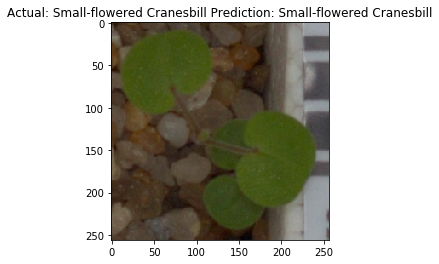

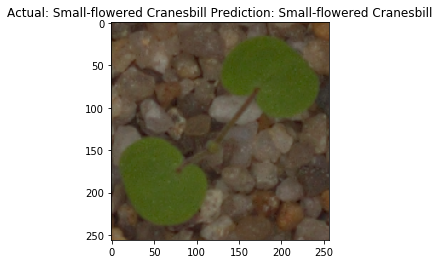

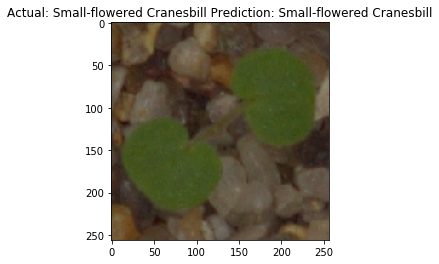

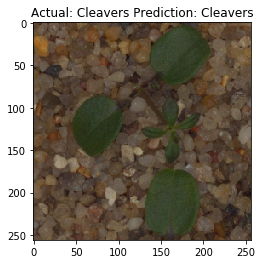

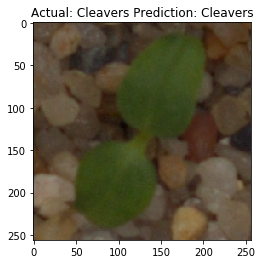

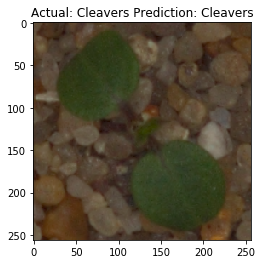

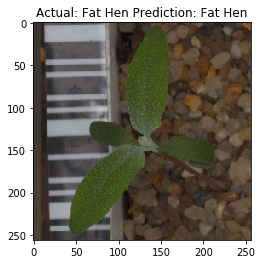

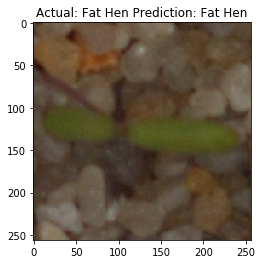

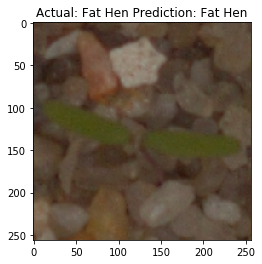

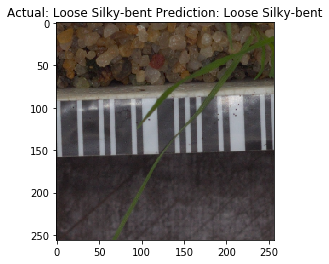

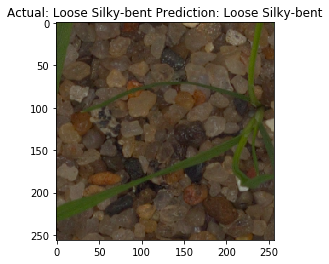

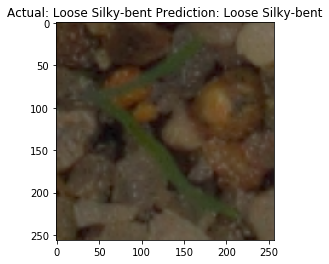

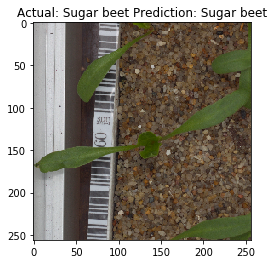

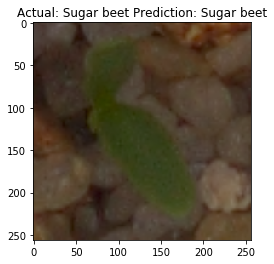

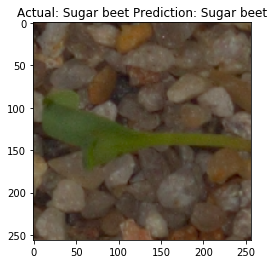

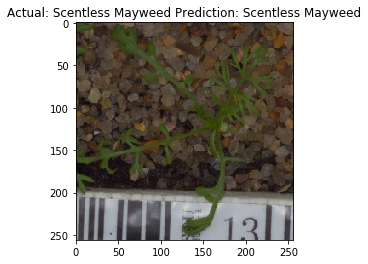

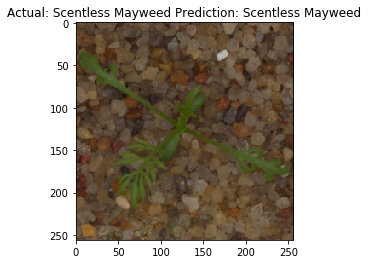

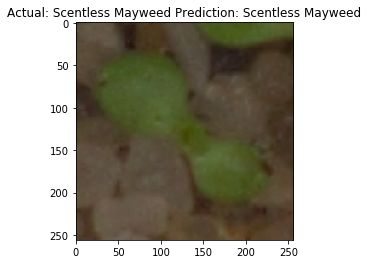

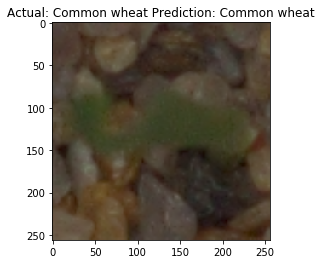

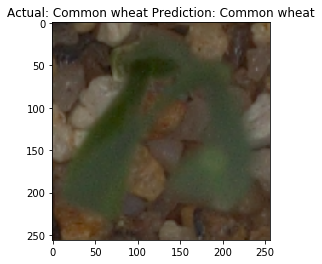

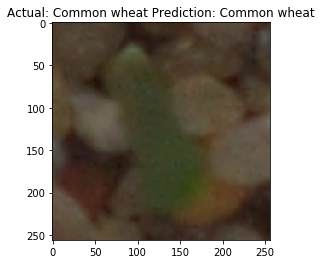

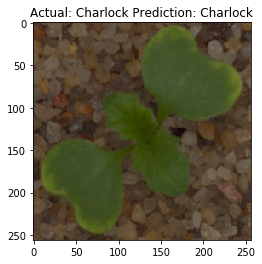

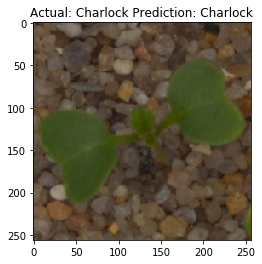

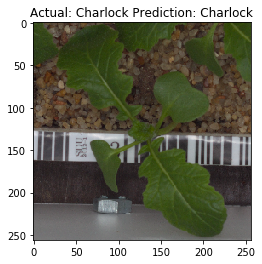

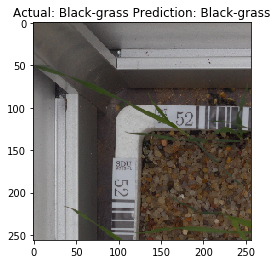

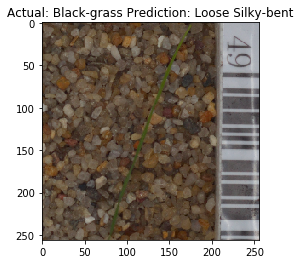

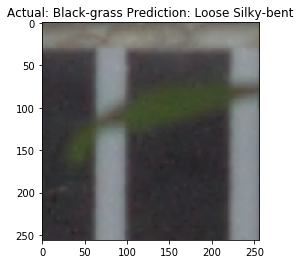

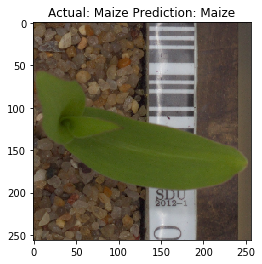

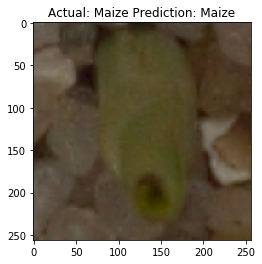

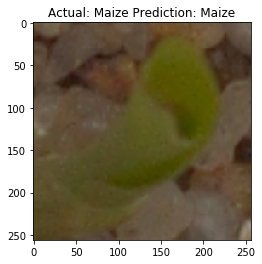

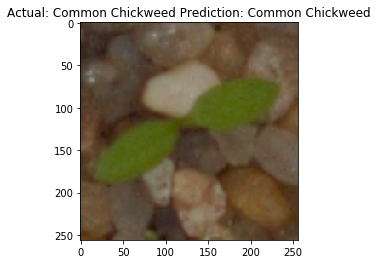

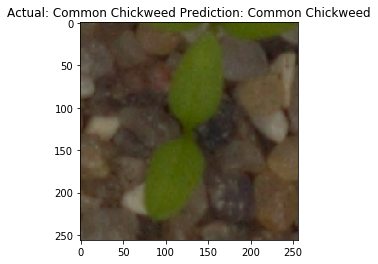

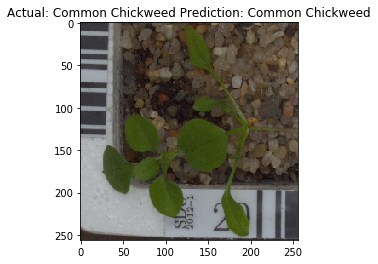

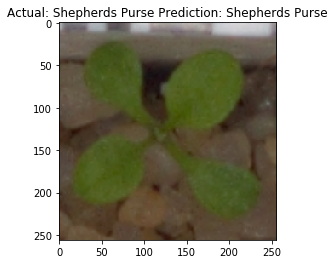

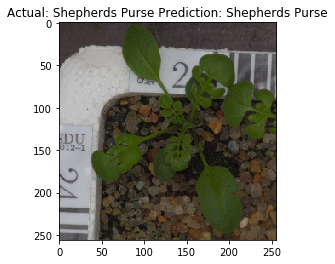

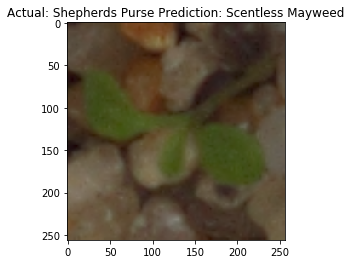

In [12]:
limit =1000
i=1
for subdir in train_dirs:
        train_images = os.listdir('train/'+subdir)
        for image_name in train_images[:3]:
            image = cv2.cvtColor(cv2.imread('train/'+subdir+'/'+image_name),cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(256,256))
            image = image.reshape((1,256,256,3))
            pred = model.predict(image)
            pred_label = np.argmax(pred,axis=1)
            pred_name = le.inverse_transform(pred_label[0])
            plt.figure()
            plt.imshow(image.reshape(256,256,3))
            plt.title('Actual: '+subdir+' Prediction: ' + pred_name)
            i=i+1
            if i>=1000:
                break
        if i>=1000:
            break
            
            

Saving to the dataframe according to the sample submission

In [8]:
import pandas as pd

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
Seeds =os.listdir('train')
label_code = LabelEncoder()
label_code.fit(Seeds)


LabelEncoder()

In [11]:
pred_label_trans = label_code.inverse_transform(labels)

NameError: name 'labels' is not defined

In [31]:
pred_label_trans

array([['Scentless Mayweed'],
       ['Scentless Mayweed'],
       ['Scentless Mayweed'],
       ['Loose Silky-bent'],
       ['Loose Silky-bent'],
       ['Small-flowered Cranesbill'],
       ['Shepherds Purse'],
       ['Black-grass'],
       ['Cleavers'],
       ['Fat Hen'],
       ['Common Chickweed'],
       ['Charlock'],
       ['Sugar beet'],
       ['Shepherds Purse'],
       ['Loose Silky-bent'],
       ['Loose Silky-bent'],
       ['Maize'],
       ['Cleavers'],
       ['Fat Hen'],
       ['Shepherds Purse'],
       ['Fat Hen'],
       ['Maize'],
       ['Loose Silky-bent'],
       ['Common Chickweed'],
       ['Common Chickweed'],
       ['Fat Hen'],
       ['Scentless Mayweed'],
       ['Sugar beet'],
       ['Loose Silky-bent'],
       ['Fat Hen'],
       ['Maize'],
       ['Common Chickweed'],
       ['Scentless Mayweed'],
       ['Fat Hen'],
       ['Common Chickweed'],
       ['Shepherds Purse'],
       ['Shepherds Purse'],
       ['Loose Silky-bent'],
       ['Loose Si

In [32]:
submission = pd.DataFrame()
submission['file']= image_name_list
submission['species'] = pred_label_trans

In [33]:
submission.head()

,file,species
0,1bf9b94a6.png,Scentless Mayweed
1,1821eb11a.png,Scentless Mayweed
2,05341a8a6.png,Scentless Mayweed
3,d09d24c58.png,Loose Silky-bent
4,be341dbdc.png,Loose Silky-bent


In [35]:
submission.to_csv('submission_vgg_rgb.csv',index=False)

#### Kaggle Score

![Image](Submission_Plant_Seeds_VGG.png)

#### Xception

Just like [[2](#Inception)], we can work on Xception model. The changes needed to apply it is

The Full code is saved as ```PlantSeedsXception.py```

In [12]:
json_file = open('xception/model_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('xception/model_final.h5')
model.summary()
images = os.listdir('data/test/')
image_name_list = []
labels=[]
for image_name in images:
    
    image = cv2.imread('data/test/'+image_name)
    image = cv2.resize(image,(256,256))
    image = image.reshape((1,256,256,3))
    pred = model.predict(image)
    pred_label = np.argmax(pred,axis=1)
    labels.append(pred_label)
    image_name_list.append(image_name)
    print(image_name+" Done!")
pred_label_trans = label_code.inverse_transform(labels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

1bf9b94a6.png Done!
1821eb11a.png Done!
05341a8a6.png Done!
d09d24c58.png Done!
be341dbdc.png Done!
410e6f702.png Done!
fea1d13d6.png Done!
71b232519.png Done!
b30ab4659.png Done!
3da774107.png Done!
bd789d151.png Done!
1cfd91582.png Done!
a800caead.png Done!
f85ed9b6d.png Done!
7696badea.png Done!
e4d5ec761.png Done!
55920f07f.png Done!
c6b76307d.png Done!
20ea96bcc.png Done!
711b46fba.png Done!
20f983a71.png Done!
71334c634.png Done!
df521c0c0.png Done!
0911d3dee.png Done!
4f44ca525.png Done!
e73e308be.png Done!
e1809cef2.png Done!
2ff5cb348.png Done!
33448fe39.png Done!
2a667e099.png Done!
0ad9e7dfb.png Done!
55a852f40.png Done!
b6f3d8b5d.png Done!
33317fc2a.png Done!
0c45ace27.png Done!
fa5fd1384.png Done!
37c3108d6.png Done!
b5c7fd009.png Done!
8585f9718.png Done!
8d6acbe9b.png Done!
35cf9fa01.png Done!
7506c0c02.png Done!
96f14d90c.png Done!
0021e90e4.png Done!
3a909ead8.png Done!
93079d970.png Done!
48ef6a2ff.png Done!
060f1dc84.png Done!
efe19dc32.png Done!
14bb43eee.png Done!


bb1c84bbc.png Done!
d41d87796.png Done!
a9d2eab61.png Done!
e5881dd33.png Done!
cfd8165e9.png Done!
0ebf8f2f4.png Done!
9df3275da.png Done!
4e69d100a.png Done!
aaf4da98f.png Done!
1f3f44563.png Done!
47f9e5d91.png Done!
ec08a5d56.png Done!
c7b07431e.png Done!
5ee9d0a5b.png Done!
25a4c427e.png Done!
9cce7328c.png Done!
809eb0b82.png Done!
76dbd1054.png Done!
64fe8beb9.png Done!
446f7da01.png Done!
0dba99002.png Done!
c7eb96871.png Done!
8e3ed0a25.png Done!
43ede9de9.png Done!
7fdb7202d.png Done!
bb64660b7.png Done!
3efa1f66c.png Done!
d93c7ab6d.png Done!
da5255450.png Done!
7d22abf91.png Done!
8cf2e3e6c.png Done!
1dc7c45df.png Done!
589e643b8.png Done!
2bd74d2da.png Done!
ba3ce6b3e.png Done!
e15472085.png Done!
a1e0a6c02.png Done!
653193c1a.png Done!
60f0bc617.png Done!
0bf7bfb05.png Done!
c7ae30f3a.png Done!
61b044411.png Done!
12625488b.png Done!
79dafec17.png Done!
9c777333d.png Done!
e721c6ac8.png Done!
87f627bf9.png Done!
558aa7deb.png Done!
37714071b.png Done!
1926e82fd.png Done!


In [13]:
submissionx = pd.DataFrame()
submissionx['file']= image_name_list
submissionx['species'] = pred_label_trans
submissionx.to_csv('submission_xception.csv',index=False)

![xception](Sub_xception2.png)

### Conclusion

So we see that, the best result comes from Xception model as of yet. Working on other models like, inception, resnet may improve it further

### Reference


1. Plant Seedlings Classification, Kaggle . [Link](https://www.kaggle.com/c/plant-seedlings-classification)
2. Transfer Learning Using Keras. [Link](https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8)